# Twitter Analysis

In this notebook we will analyse about 3000 tweets twittered by Donald Trump, the current president of the US. The tweets range from October 2016 until 15. January 2018. Before you can execute this notebook you need to make sure that you have installed all packages from the requirements.txt by calling:

```
pip install -r requirements.txt
```

**Note:** Depending on your OS you might have to use [conda](https://www.anaconda.com/download/). In general we encourage the use of a virtual environment for your python distribution.
After completing those steps you need to download the tweets via:

```
python data/download_tweets.py --user_name realDonaldTrump --count 3500
```

After that you need to preprocess it and transform the tweets into a data table:

```
python data/make_dataset.py --tweets True
```

### Question: Which topics were most tweeted about by Donald Trump?

In [1]:
# Load the "autoreload" extension
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import datetime
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

import re
# add the 'src' directory as one where we can import modules
src_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'src'))
sys.path.append(src_dir)

# self written packages
from data import data_utils
from data.preprocessing import preprocess
from data.preprocessing import remove_stopwords
from data.preprocessing import preprocess_tweets
from data.preprocessing import create_dataframe_from_json

## Features

- id_str is a unique identifier for tweets issued by Twitter
- created_at is the date of creation for a tweet
- full_text is the full text of a tweet
- favorite_count is the count of how many people clicked the "like" button on one of the tweets
- retweet_count is the count of how many people retweeted the tweet
- retweeted indicates whether Donald Trump retweeted a tweet (==1) or he wrote it himself (==0)

### Read files from directory of processed data tables

In [2]:
file_name = "realDonaldTrump_tweets.csv"
data_dir = os.path.join(data_utils.get_data_dir(),"processed", file_name)
data = pd.read_csv(data_dir, sep=";", infer_datetime_format=True)
data["created_at"] = pd.to_datetime(data["created_at"])
data.head(5)

,id_str,created_at,full_text,favorite_count,retweet_count,retweeted
0,953000902331453442,2018-01-15 20:28:15,senator dicky durbin totally misrepresented wh...,9898,3043,0
1,952933691642339329,2018-01-15 16:01:11,dr king s dream is our dream it is the america...,0,11421,1
2,952888691944550401,2018-01-15 13:02:22,to stop drugs they want to take money away fro...,79559,17328,0
3,952887520790040576,2018-01-15 12:57:43,statement by me last night in florida honestly...,65684,15890,0
4,952540700683497472,2018-01-14 13:59:35,big unnecessary regulation cuts made it all po...,76061,17115,0


In [3]:
print("We gathered {} tweets.".format(data.shape[0]))

We gathered 3203 tweets.


### One example tweet: 

In [4]:
data.head(1)["full_text"][0]

'senator dicky durbin totally misrepresented what was said at the daca meeting deals can t get made when there is no trust durbin blew daca and is hurting our military'

### There are still a lot of stopwords in the data which should be removed:

In [5]:
data["words_only"] = remove_stopwords(data["full_text"])

Now we have only the "important" words left:

In [6]:
data.head(1)["words_only"][0]

'senator,dicky,durbin,totally,misrepresented,said,daca,meeting,deals,get,made,trust,durbin,blew,daca,hurting,military'

### Tweets per week

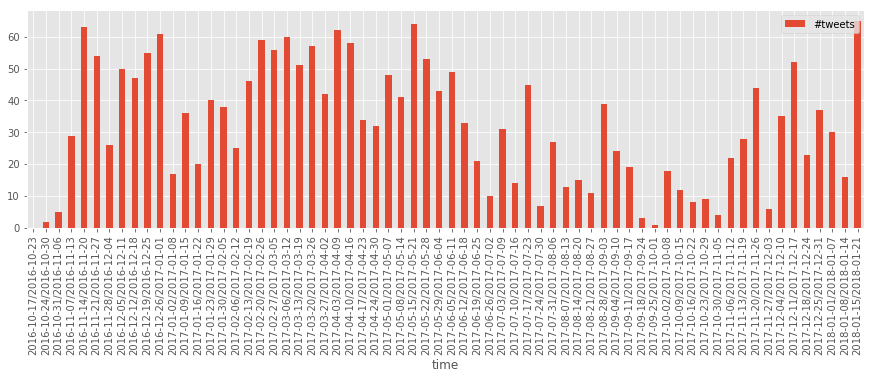

In [7]:
tweet_days = data["created_at"].dt.to_period('W')
tweets_per_day = tweet_days.value_counts().to_frame().reset_index()

tweets_per_day = tweets_per_day.rename(columns={'created_At': '#tweets', 'index': 'time'})
tweets_per_day_sorted = tweets_per_day["time"].sort_values().to_frame().reset_index()
tweets_per_day_sorted = tweets_per_day_sorted.rename(columns={'index': '#tweets'})
tweets_per_day_sorted.set_index("time").plot(kind='bar', figsize=(15,4));


### Distribution of retweets:

From this we can say that Donald Trump is definetly a very active author of tweets and retweeting other tweets is not that common.

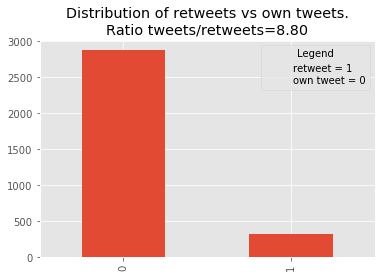

In [8]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()

handles, labels = ax.get_legend_handles_labels()
handles.append(mpatches.Patch(color="none",label="retweet = 1\nown tweet = 0"))
ax.legend(handles=handles,title='Legend')
ratio = data["retweeted"].value_counts()[0]/data["retweeted"].value_counts()[1]
ax.set_title("Distribution of retweets vs own tweets.\nRatio tweets/retweets={:.2f}".format(ratio))
data["retweeted"].value_counts().plot(kind='bar', ax=ax);

### Time Series of likes per week

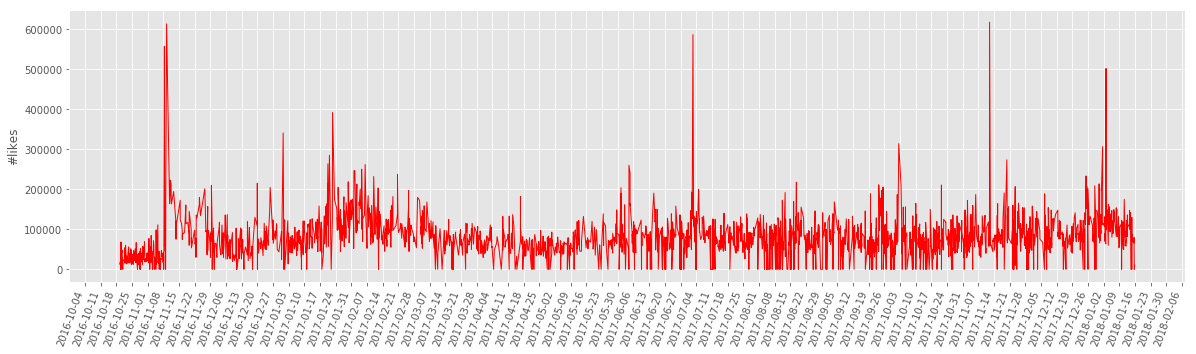

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=70, horizontalalignment='right')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.plot_date(data["created_at"], data.favorite_count, "-",lw=1,color="red")
#ax.plot_date(data["created_at"], data.retweet_count, "-",lw=1,color="blue")

plt.ylabel("#likes")
plt.show();

### Most "liked" tweets:

In [10]:
index_mask = list(data[data.favorite_count > 400000].index)
display(data.iloc[index_mask])
print("Tweets in detail:\n")
for row in data.loc[index_mask,"full_text"]:
    print(row)
    print("\n")

,id_str,created_at,full_text,favorite_count,retweet_count,retweeted,words_only
94,948355557022420992,2018-01-03 00:49:19,north korean leader kim jong un just stated th...,501885,194426,0,"north,korean,leader,kim,jong,un,stated,nuclear..."
448,929511061954297857,2017-11-12 00:48:01,why would kim jong un insult me by calling me ...,617466,271553,0,"would,kim,jong,un,insult,calling,old,would,nev..."
1620,881503147168071680,2017-07-02 13:21:42,fraudnewscnn fnn,586486,361642,0,"fraudnewscnn,fnn"
2864,796315640307060738,2016-11-09 11:36:58,such a beautiful and important evening the for...,613222,211232,0,"beautiful,important,evening,forgotten,man,woma..."
2876,795954831718498305,2016-11-08 11:43:14,today we make america great again,557279,331035,0,"today,make,america,great"


Tweets in detail:

north korean leader kim jong un just stated that the nuclear button is on his desk at all times will someone from his depleted and food starved regime please inform him that i too have a nuclear button but it is a much bigger amp more powerful one than his and my button works


why would kim jong un insult me by calling me old when i would never call him short and fat oh well i try so hard to be his friend and maybe someday that will happen


fraudnewscnn fnn


such a beautiful and important evening the forgotten man and woman will never be forgotten again we will all come together as never before


today we make america great again




### Time Series of retweets per week

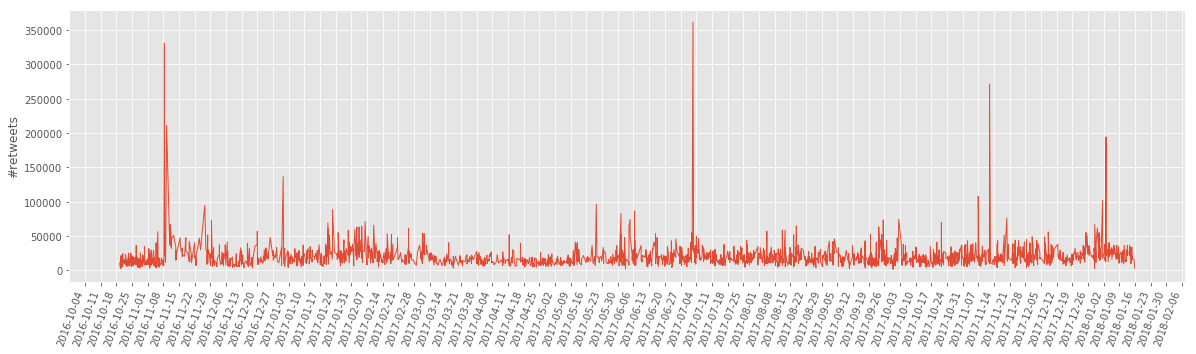

In [11]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.setp( ax.xaxis.get_majorticklabels(), rotation=70, horizontalalignment='right')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.plot_date(data["created_at"], data.retweet_count, "-",lw=1)
plt.ylabel("#retweets")
plt.show();

### Most retweeted posts:

Note that they are the same as the most liked posts

In [12]:
index_mask = list(data[data.retweet_count > 150000].index)
display(data.iloc[index_mask])

,id_str,created_at,full_text,favorite_count,retweet_count,retweeted,words_only
94,948355557022420992,2018-01-03 00:49:19,north korean leader kim jong un just stated th...,501885,194426,0,"north,korean,leader,kim,jong,un,stated,nuclear..."
448,929511061954297857,2017-11-12 00:48:01,why would kim jong un insult me by calling me ...,617466,271553,0,"would,kim,jong,un,insult,calling,old,would,nev..."
1620,881503147168071680,2017-07-02 13:21:42,fraudnewscnn fnn,586486,361642,0,"fraudnewscnn,fnn"
2864,796315640307060738,2016-11-09 11:36:58,such a beautiful and important evening the for...,613222,211232,0,"beautiful,important,evening,forgotten,man,woma..."
2876,795954831718498305,2016-11-08 11:43:14,today we make america great again,557279,331035,0,"today,make,america,great"


### 5 most common hashtags:


In [13]:
# need unpreprocessed data as hashtags are removed during preprocessing
file_name = "realDonaldTrump_tweets.json"
data_dir = os.path.join(data_utils.get_data_dir(),"raw","realDonaldTrump", file_name)
raw_data = create_dataframe_from_json(data_dir)


In [14]:
hashtags = [term.decode() for term in list(raw_data['full_text']) 
              if term.decode().startswith('#')]
reg_string =  [r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"]
hashtag_re = re.compile(r'('+'|'.join(reg_string)+')', re.VERBOSE | re.IGNORECASE)
cleaned_hashtags = [hashtag_re.findall(tag) for tag in hashtags]
# concatenate all separate lists
cleaned_hashtags = [inner
                    for outer in cleaned_hashtags
                        for inner in outer]

In [15]:
from collections import Counter
nr_of_hashtags = 5
most_common = Counter(cleaned_hashtags).most_common(nr_of_hashtags)
colnames = [tag for tag,_ in most_common]
counts = np.array([count for _,count in most_common])
counts.shape = (1,nr_of_hashtags)
hashtag_ranking = pd.DataFrame(counts, columns=colnames).T.rename(columns={0:"count"})
hashtag_ranking

,count
#ICYMI,8
#CrookedHillary,6
#DrainTheSwamp,5
#ObamacareFail,5
#USA,5


## Topics

### Take a look at the 10 most common ngrams where n=3

ngrams are words which are "next" to each other. This means if words are often placed together they will be put into one tuple. This tuple can be counted and ranked to get a sense of which topics are most tweeted about by President Trump.

In [16]:
from nltk import ngrams
import nltk

# remove inflections e.g. like, likely are both changed to like
# this results in cleaner results
terms = [term for tweet in data.words_only for term in tweet.split(',')] 
lemma = nltk.wordnet.WordNetLemmatizer()
lemmatized_terms = [lemma.lemmatize(term) for term in terms]
terms_bigram = ngrams(lemmatized_terms,3)

nr_of_ngrams = 10
most_common = Counter(terms_bigram).most_common(nr_of_ngrams)
colnames = [tag for tag,_ in most_common]
counts = np.array([count for _,count in most_common])
counts.shape = (1,nr_of_ngrams)
ngram_ranking = pd.DataFrame(counts, columns=colnames).T.reset_index().rename(columns={0:"count","index":"ngram"})
ngram_ranking

,ngram,count
0,"(make, america, great)",79
1,"(fake, news, medium)",42
2,"(tax, cut, reform)",25
3,"(crooked, hillary, clinton)",18
4,"(massive, tax, cut)",18
5,"(job, job, job)",15
6,"(stock, market, hit)",12
7,"(making, america, great)",12
8,"(fake, news, cnn)",11
9,"(tax, cut, bill)",11


## Wordcloud

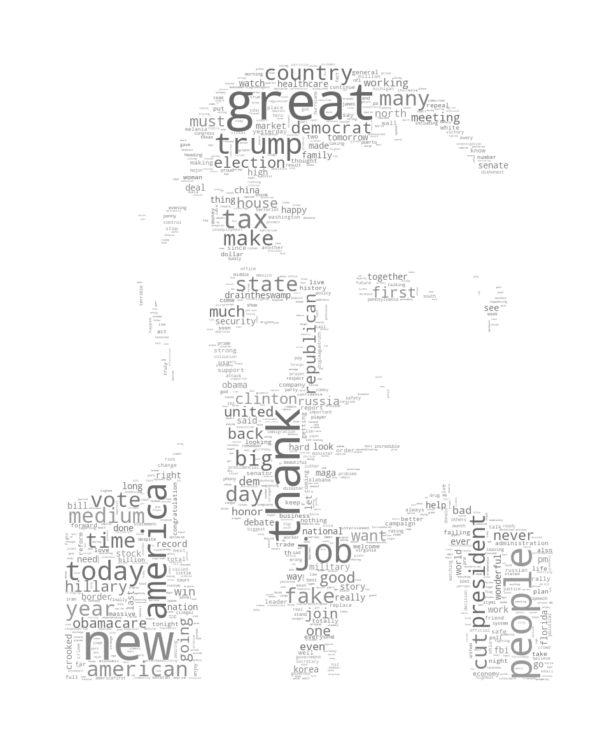

In [17]:
from wordcloud import WordCloud
from PIL import Image
import random
import nltk
# code taken from minimal example of wordcloud package:
# https://github.com/amueller/word_cloud/blob/master/examples/simple.py
# picture of donald trump taken from
#http://www.freestencilgallery.com/donald-trump-stencil/
trump_mask = np.array(Image.open("Donald-Trump-Stencil-1.jpg"))

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # code from documentation:https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
    return "hsl(0, 0%%, %d%%)" % random.randint(40, 60)


text = " ".join(lemmatized_terms)
wordcloud = WordCloud(background_color="white",mask=trump_mask,max_words=2000, width=600, height=800,color_func=grey_color_func)
wordcloud.generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show();